In [5]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import scipy.special
import scipy
import logging
import os
from util import getDefaultHyperparams, modelComplexity
import time
from DayDataloaders import create_Dataloaders
# Import the metrics file
from SequenceLoss import SequenceLoss
from network import Net, RSNNet
from RNN_network import RNN
import pickle



In [3]:


# Function to load and plot metrics
def plot_metrics(file_path):
    metrics = torch.load(file_path)

    trainloss_per_epoch = np.array(metrics['trainloss_per_epoch'])
    trainacc_per_epoch = np.array(metrics['trainacc_per_epoch'])
    valloss_per_epoch = np.array(metrics['valloss_per_epoch'])
    valacc_per_epoch = np.array(metrics['valacc_per_epoch'])

    max_val = 1
    count = len(valacc_per_epoch[valacc_per_epoch < max_val])
    print(count)

    fig, axs = plt.subplots(2, 1, figsize=(15, 10))
    axs[0].plot(trainloss_per_epoch[valacc_per_epoch < max_val], label='train loss')
    axs[0].plot(valloss_per_epoch[valacc_per_epoch < max_val], label='val loss')
    axs[0].set_ylabel('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_title('Loss per Epoch')
    axs[0].legend()

    axs[1].plot(trainacc_per_epoch[valacc_per_epoch < max_val], label='train acc')
    axs[1].plot(valacc_per_epoch[valacc_per_epoch < max_val], label='val acc')
    axs[1].axhline(y=0.85, linestyle='--', color='black')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_title('Accuracy per Epoch')
    axs[1].legend()

    #plt.savefig('C:/Users/pietr/OneDrive/Documenti/PIETRO/ETH/SS24/Semester_project/VARIE/REPORT/' + 'RSNN' +'_plot.png', transparent= False, dpi=600,bbox_inches='tight' )
    plt.show()
    

1241


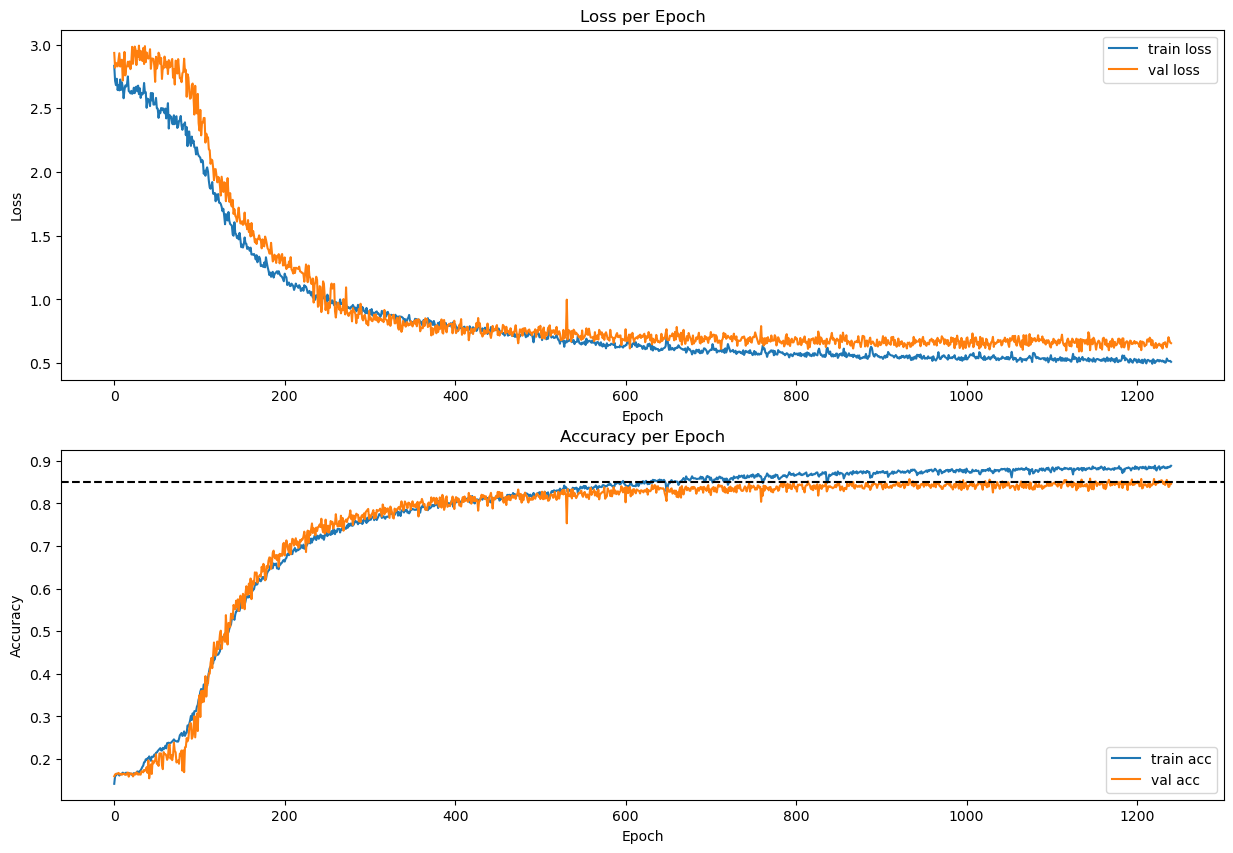

In [6]:
#metrics_path = '../Files/trainOutputs/metrics_971220.pth'
#metrics_path = '../Files/trainOutputs/metrics_775245.pth'
#metrics_path = '../Files/trainOutputs/metrics_367140.pth' # 0 dropour, higher noise

metrics_path = '../Files/trainOutputs/metrics_285596.pth' # 0 dropout, lower noise !
#metrics_path = '../Files/trainOutputs/metrics_622981.pth' # 0.3 dropout, lower noise !!!

#metrics_path = '../Files/trainOutputs/metrics_930085.pth' # no final nospike layer, 0 dropot, lower noise
plot_metrics(metrics_path)


In [7]:

#s = 120
e = 50
s = e - 10
metrics = torch.load(metrics_path)
trainloss_per_epoch = metrics['trainloss_per_epoch']
trainacc_per_epoch = metrics['trainacc_per_epoch']
valloss_per_epoch = metrics['valloss_per_epoch']
valacc_per_epoch = metrics['valacc_per_epoch']
print('Train acc: ', np.round(trainacc_per_epoch[s+1:e+1], 4))
print('Train loss: ',np.round(trainloss_per_epoch[s+1:e+1], 4))
print('')
print('Val acc: ', np.round(valacc_per_epoch[s+1:e+1], 4))
print('Val loss: ',np.round(valloss_per_epoch[s+1:e+1], 4))





Train acc:  [0.2063 0.1998 0.196  0.2056 0.2053 0.2054 0.2106 0.2081 0.2148 0.2154]
Train loss:  [2.5506 2.5174 2.6205 2.5625 2.6196 2.5293 2.5296 2.5328 2.5818 2.5004]

Val acc:  [0.1548 0.1724 0.1874 0.1651 0.1956 0.1899 0.1943 0.1972 0.2109 0.1888]
Val loss:  [2.9092 2.9637 2.8101 2.8895 2.8907 2.8871 2.8357 2.7075 2.9042 2.8128]


In [ ]:
# Function to smooth metrics with a running mean
def running_mean(x, N):
    return np.convolve(x, np.ones(N)/N, mode='valid')

# Function to load and plot metrics with smoothing
def InfIters_plot_metrics(file_path):
    metrics = torch.load(file_path)
    train_loss = metrics['train_loss']
    train_acc = metrics['train_acc']
    val_loss = metrics['val_loss']
    val_acc = metrics['val_acc']

    # Smooth metrics with running mean (window size = 10)
    train_loss_smooth = running_mean(train_loss, 10)
    train_acc_smooth = running_mean(train_acc, 10)
    val_loss_smooth = running_mean(val_loss, 10)
    val_acc_smooth = running_mean(val_acc, 10)

    train_len = len(train_loss_smooth)
    val_range = np.linspace(0, train_len, len(val_loss_smooth))

    fig, axs = plt.subplots(2, 1, figsize=(15, 10))
    axs[0].plot(train_loss_smooth, label='train loss (smoothed)')
    axs[0].plot(val_range, val_loss_smooth, label='val loss (smoothed)')
    axs[0].set_ylabel('Loss')
    axs[0].set_xlabel('Batch')
    axs[0].set_title('Loss per Batch')
    axs[0].legend()

    axs[1].plot(train_acc_smooth, label='train acc (smoothed)')
    axs[1].plot(val_range, val_acc_smooth, label='val acc (smoothed)')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_xlabel('Batch')
    axs[1].set_title('Accuracy per Batch')
    axs[1].legend()

    plt.savefig('C:/Users/pietr/OneDrive/Documenti/PIETRO/ETH/SS24/Semester_project/VARIE/REPORT/' + 'SNN' +'_plot.png', transparent= False, dpi=600,bbox_inches='tight' )
    #plt.show()


metrics_path = 'Model/metrics_inf_107776.pth'
InfIters_plot_metrics(metrics_path)

In [16]:
hyperparams = getDefaultHyperparams()

if hyperparams['system'] == 'Linux':
    prepared_data_dir = '/scratch/sem24f8/dataset/'
else:
    prepared_data_dir = 'dataset/'

hyperparams['prepared_data_dir'] = prepared_data_dir

hyperparams['n_channels'] = 192
hyperparams['n_outputs'] = 32
hyperparams['batchSize'] = 2


# Load the prepared data
print('Loading prepared data from dir')
prepared_data = torch.load(prepared_data_dir + 'prepared_data.pth')
print('Data loaded')

manual_prep = False
# loading the testing dataset and creating a DataLoader for each day
Test_finite_loader = create_Dataloaders(manual_prep, hyperparams, days=np.arange(10), mode='testing')
test_loaders = Test_finite_loader.getDataloaders()
viable_test_days = Test_finite_loader.getViableDays()
print('Testing dataloaders ready')



Loading prepared data from dir
Data loaded
Loading prepared data from dir
Data loaded
Testing dataloaders ready


In [18]:
hyperparams['network_type'] = 'RSNN'
# MODEL ID
#id = '971220' # RNN
#id = '462396' # RSNN
#id = '555656' # RSNN 2
#id = '775245'
#id = '367140'

#id = '285596'
id = '622981'

#id = '930085'

hyperparams['id'] = id
#MACs, ACs = modelComplexity(hyperparams)
#print(f"Number of MACs: {np.ceil(MACs):.0f}")
#print(f"Number of ACs: {np.ceil(ACs):.0f}")


In [20]:

def evaluateSNNOutput(snnOutput, numBinsPerSentence, trueText, charDef, charStartThresh=0.3, charStartDelay=15):
    """
    Converts the snn output (character probabilities & a character start signal) into a discrete sentence and computes
    char/word error rates. Returns error counts and the decoded sentences.
    Relatively to the original code here the dimensions are swapped: (B x T x C) -> (B x C x T)
    """  
    lgit = snnOutput[:,0:-1,:]
    charStart = snnOutput[:,-1,:]

    trueText = trueText.squeeze()
    numBinsPerSentence = numBinsPerSentence.squeeze()

    #convert output to character strings
    decStr = decodeCharStr(lgit, charStart, charStartThresh, charStartDelay, 
                           numBinsPerSentence, charDef['charListAbbr'])

    allErrCounts = {}
    allErrCounts['charCounts'] = np.zeros([len(trueText)])
    allErrCounts['charErrors'] = np.zeros([len(trueText)])
    allErrCounts['wordCounts'] = np.zeros([len(trueText)])
    allErrCounts['wordErrors'] = np.zeros([len(trueText)])
    
    allDecSentences = []

    #compute error rates
    for t in range(len(trueText)):
        thisTrueText = trueText[t][0]
        thisTrueText = thisTrueText.replace(' ','')
        thisTrueText = thisTrueText.replace('>',' ')
        thisTrueText = thisTrueText.replace('~','.')
        thisTrueText = thisTrueText.replace('#','')

        thisDec = decStr[t]
        thisDec = thisDec.replace('>',' ')
        thisDec = thisDec.replace('~','.')

        nCharErrors = wer(list(thisTrueText), list(thisDec))
        nWordErrors = wer(thisTrueText.strip().split(), thisDec.strip().split())
        
        allErrCounts['charCounts'][t] = len(thisTrueText)
        allErrCounts['charErrors'][t] = nCharErrors
        allErrCounts['wordCounts'][t] = len(thisTrueText.strip().split())
        allErrCounts['wordErrors'][t] = nWordErrors

        allDecSentences.append(thisDec)

    return allErrCounts, allDecSentences




def decodeCharStr(logitMatrix, transSignal, transThresh, transDelay, numBinsPerTrial, charList):
    """
    Converts the snn output (character probabilities & a character start signal) into a discrete sentence.
    """
    decWords = []
    for v in range(logitMatrix.shape[0]):
        logits = np.squeeze(logitMatrix[v,:,:])
        #plt.imshow(logits, cmap='binary', aspect='auto')
        #plt.show()
        bestClass = np.argmax(logits, axis=0)
        #plt.plot(transSignal[v,:])
        #plt.show()
        letTrans = scipy.special.expit(transSignal[v,:])

        endIdx = np.ceil(numBinsPerTrial[v]).astype(int)
        letTrans = letTrans[0:endIdx]
        transIdx = np.argwhere(np.logical_and(letTrans[0:-1]<transThresh, letTrans[1:]>transThresh))
        transIdx = transIdx[:,0]
        
        wordStr = ''
        for x in range(len(transIdx)):
            wordStr += charList[bestClass[transIdx[x]+transDelay]]

        decWords.append(wordStr)
        
    return decWords





def wer(r, h):
    """
    Calculation of WER with Levenshtein distance.

    Works only for iterables up to 254 elements (uint8).
    O(nm) time ans space complexity.

    Parameters
    ----------
    r : list
    h : list

    Returns
    -------
    int

    Examples
    --------
    >>> wer("who is there".split(), "is there".split())
    1
    >>> wer("who is there".split(), "".split())
    3
    >>> wer("".split(), "who is there".split())
    3
    """
    # initialisation
    import numpy
    d = numpy.zeros((len(r)+1)*(len(h)+1), dtype=numpy.uint8)
    d = d.reshape((len(r)+1, len(h)+1))
    for i in range(len(r)+1):
        for j in range(len(h)+1):
            if i == 0:
                d[0][j] = j
            elif j == 0:
                d[i][0] = i

    # computation
    for i in range(1, len(r)+1):
        for j in range(1, len(h)+1):
            if r[i-1] == h[j-1]:
                d[i][j] = d[i-1][j-1]
            else:
                substitution = d[i-1][j-1] + 1
                insertion    = d[i][j-1] + 1
                deletion     = d[i-1][j] + 1
                d[i][j] = min(substitution, insertion, deletion)

    return d[len(r)][len(h)]

In [21]:
from util import getHandwritingCharacterDefinitions, extractBatch, tensors_to_numpy, computeFrameAccuracy, computeTransSignalAccuracy

def testModel(model, test_loaders, viable_test_days ,criterion, hyperparams, device):

    charDef = getHandwritingCharacterDefinitions()
    allErrCounts = []
    predictions = {}

    model.eval()

    with torch.no_grad():

        for idx_loader in range(len(test_loaders)):

            print(f"Testing on day {hyperparams['dataDirs'][viable_test_days[idx_loader]]}")

            test_loader = iter(test_loaders[idx_loader])
            num_batches = len(test_loaders[idx_loader])

            running_loss = 0.0
            running_acc = 0.0
            running_transAcc = 0.0
            running_transRMSE = 0.0
            test_progress = "Testing progress: |"

            outputs = []

            for i in range(num_batches):

                trial_iter = next(test_loader)
                data, targets, errWeights = extractBatch(trial_iter, hyperparams, device)
                if hyperparams['network_type'] != 'RNN':
                    output, spikecounts = model(data)
                else:
                    output = model(data)
                loss = criterion(output, targets, errWeights)
                running_loss += loss.item()
                output, targets, errWeights = tensors_to_numpy(output, targets, errWeights)
                acc = computeFrameAccuracy(output, targets, errWeights, hyperparams['outputDelay'])
                transAcc, transRMSE = computeTransSignalAccuracy(output, targets, errWeights, hyperparams['outputDelay'])

                running_acc += acc
                running_transAcc += transAcc
                running_transRMSE += transRMSE

                #if i%(np.ceil(num_batches/100))==0:
                #test_progress += "#"
                #print(f"{test_progress} {loss.item():.4f}", end='\r')

                outputs.append(output)
            
            print('')

            outputs = np.concatenate(outputs, axis=0)
            num_sentences = outputs.shape[0]
            print(f"Number of sentences of the day: {num_sentences}")

            avg_loss = running_loss / num_batches
            avg_acc = running_acc / num_batches
            avg_transAcc = running_transAcc / num_sentences
            avg_transRMSE = running_transRMSE / num_sentences
            
            print(f"Average loss: {avg_loss:.4f}")
            print(f"Average accuracy: {avg_acc:.4f}")
            print(f"Average transAcc: {avg_transAcc:.6f}")
            print(f"Average transRMSE: {avg_transRMSE:.4f}")

            predictions[hyperparams['dataDirs'][viable_test_days[idx_loader]]] = outputs
            

            # Character error rate and Word error rate computation
            dayIdx = viable_test_days[idx_loader]
            cvPartFile = scipy.io.loadmat(hyperparams['cvPartitionFile_'+str(dayIdx)])
            testIdx = cvPartFile[hyperparams['dataDirs'][dayIdx]+'_test']
                                                    
            sentenceDat = scipy.io.loadmat(hyperparams['sentencesFile_'+str(dayIdx)])

            errCounts, decSentences = evaluateSNNOutput(outputs, sentenceDat['numTimeBinsPerSentence'][testIdx] / hyperparams['rnnBinSize'] + hyperparams['outputDelay'],
                                                        sentenceDat['sentencePrompt'][testIdx],
                                                        charDef,
                                                        charStartThresh=0.3,
                                                        charStartDelay=15)
            
            #save decoded sentences, character error rates and word error rates for later summarization
            saveDict = {}
            saveDict['decSentences'] = decSentences
            saveDict['trueSentences'] = sentenceDat['sentencePrompt'][testIdx]
            saveDict.update(errCounts)
                    
            valAcc = 100*(1 - np.sum(errCounts['charErrors']) / np.sum(errCounts['charCounts']))

            print('Character error rate for this session: %1.2f%%' % float(100-valAcc))
            print('Below is the decoder output for all validation sentences in this session:')
            print(' ')
            
            for v in np.arange(num_sentences):
                trueText = sentenceDat['sentencePrompt'][testIdx].squeeze()[v][0]
                trueText = trueText.replace('>',' ')
                trueText = trueText.replace('~','.')
                trueText = trueText.replace('#','')
                
                print('#' + str(v) + ':')
                print('True:    ' + trueText)
                print('Decoded: ' + decSentences[v])
                print(' ')
        
            #put together all the error counts from all sessions so we can compute overall error rates below
            allErrCounts.append(np.stack([errCounts['charCounts'],
                                    errCounts['charErrors'],
                                    errCounts['wordCounts'],
                                    errCounts['wordErrors']],axis=0).T)
        
    
    # Save predicitons
    predictions_file = 'inferOutputs/' + 'predictions.mat'
    scipy.io.savemat(predictions_file, predictions)

    # Summarize character error rate and word error rate across all sessions
    concatErrCounts = np.squeeze(np.concatenate(allErrCounts, axis=0))
    cer = 100*(np.sum(concatErrCounts[:,1]) / np.sum(concatErrCounts[:,0]))
    wer = 100*(np.sum(concatErrCounts[:,3]) / np.sum(concatErrCounts[:,2]))

    print('Character error rate: %1.2f%%' % float(cer))
    print('Word error rate: %1.2f%%' % float(wer))

In [22]:
# Load the model
device = torch.device('cpu')
if torch.cuda.is_available():
    print('GPU available')
    device = torch.device(hyperparams['device'])
print(f'Device: {device}')

model = torch.load(f'../Files/Model/model_{id}.pth', map_location=device)


# test the model
criterion = SequenceLoss(hyperparams)
testModel(model, test_loaders, viable_test_days, criterion, hyperparams, device)

GPU available
Device: cuda
Testing on day t5.2019.11.25

Number of sentences of the day: 32
Average loss: 2.5754
Average accuracy: 0.8550
Average transAcc: 0.027175
Average transRMSE: 0.1338
Character error rate for this session: 9.29%
Below is the decoder output for all validation sentences in this session:
 
#0:
True:    the quick brown fox jumps over the lazy dog
Decoded: the quickk brown fo,, g ups oven tho la y  do
 
#1:
True:    imagine all the people living life in peace
Decoded: imagine all the people living lfo n peace
 
#2:
True:    ask not what your country can do for you
Decoded: ask not what your coumtry can do for you
 
#3:
True:    i heard my friend is going into town today
Decoded: i heard myyffneend is going into town today
 
#4:
True:    you must be the change you wish to see in the world
Decoded: kou must be the change you wish to see in theworld
 
#5:
True:    when the sunlight strikes raindrops in the air
Decoded: when the sunlght strikes raindrops in the air
 
#6: